In [202]:
from dolfin import *
import numpy as np

%matplotlib inline
from dolfin.plotting import plot

# Define input data
from ufl import SpatialCoordinate, inner, grad, lhs, rhs, dot, exp, Measure, dx, ds
from dolfin.fem import assemble_scalar

In [203]:
import dolfin
dolfin.__version__

'2018.2.0.dev0'

In [204]:
# Create classes for defining parts of the boundaries and the interior
# of the domain
class Left(SubDomain):
    def inside(self, x, on_boundary):
         return np.logical_and(x[:, 0] < np.finfo(float).eps, on_boundary)

class Right(SubDomain):
    def inside(self, x, on_boundary):
         return np.logical_and(x[:, 0] > 1 - np.finfo(float).eps, on_boundary)

class Bottom(SubDomain):
    def inside(self, x, on_boundary):
         return np.logical_and(x[:, 1] < np.finfo(float).eps, on_boundary)

class Top(SubDomain):
    def inside(self, x, on_boundary):
         return np.logical_and(x[:, 1] > 1 - np.finfo(float).eps, on_boundary)
    
class Obstacle(SubDomain):
    def inside(self, x, on_boundary):
        return np.logical_and(np.logical_and(x[:, 0] <= 1.0,
                              x[:, 0] > 0.2 - np.finfo(float).eps),
                              np.logical_and(x[:, 1] < 0.7 + np.finfo(float).eps,
                              x[:, 1] > 0.5 - np.finfo(float).eps))

In [205]:
# Initialize sub-domain instances
left = Left()
top = Top()
right = Right()
bottom = Bottom()
obstacle = Obstacle()

In [206]:
# Define mesh
mesh = UnitSquareMesh(dolfin.MPI.comm_world,58, 58)

In [226]:
mesh.num_cells()

6728

In [207]:
# Initialize mesh function for boundary domains
boundaries = MeshFunction("size_t", mesh, mesh.topology.dim - 1,0)
left.mark(boundaries, 1)
top.mark(boundaries, 2)
right.mark(boundaries, 3)
bottom.mark(boundaries, 4)

In [208]:
# Initialize mesh function for interior domains
domains = MeshFunction("size_t", mesh, mesh.topology.dim,5)
obstacle.mark(domains, 6)

In [209]:
a0 = 1.0
a1 = 0.01
x = SpatialCoordinate(mesh)
g_L = exp(- 10*(- pow(x[1] - 0.5, 2)))
g_R = 1.0
f = 1.0

In [210]:
# Define function space and basis functions
V = FunctionSpace(mesh, ("CG", 2))
u = TrialFunction(V)
v = TestFunction(V)

In [211]:
u5 = Function(V)
with u5.vector().localForm() as bc_local:
    bc_local.set(5.0)

u0 = Function(V)
with u0.vector().localForm() as bc_local:
    bc_local.set(0.0)

In [212]:
# Define Dirichlet boundary conditions at top and bottom boundaries
bcs = [DirichletBC(V, u5, boundaries.where_equal(2)),
       DirichletBC(V, u0, boundaries.where_equal(4))]

In [213]:
dx = dx(subdomain_data=domains)
ds = ds(subdomain_data=boundaries)

In [214]:
# Define variational form
F = (inner(a0*grad(u), grad(v))*dx(5) + inner(a1*grad(u), grad(v))*dx(6)
     - g_L*v*ds(1) - g_R*v*ds(3)
     - f*v*dx(5) - f*v*dx(6))

In [215]:
# Separate left and right hand sides of equation
a, L = lhs(F), rhs(F)

In [216]:
# Solve problem
u = Function(V)
solve(a == L, u, bcs)

In [225]:
bb_tree = cpp.geometry.BoundingBoxTree(mesh, mesh.geometry.dim)
u([0.5, 0.5], bb_tree)[0]

1.0363053455199278

In [218]:
max(u.vector().array)

10.847105065005907

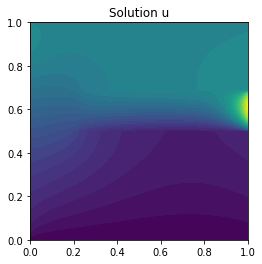

In [219]:
plot(u, title="Solution u")

In [220]:
from numpy import linspace
from matplotlib.pyplot import plot

xval = linspace(0,1,10)

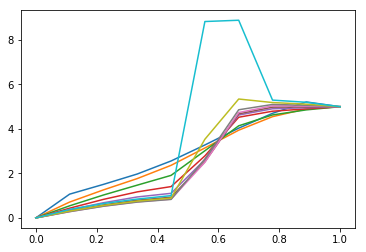

In [221]:
for x in xval:
    yval=[u([x, y], bb_tree)[0] for y in xval]
    plot(xval, yval)

In [222]:
# Evaluate integral of normal gradient over top boundary
n = FacetNormal(mesh)
m1 = dot(grad(u), n)*ds(2)
v1 = assemble_scalar(m1)
print("\int grad(u) * n ds(2) = ", v1)

\int grad(u) * n ds(2) =  -0.5873100128573697


In [224]:
# Evaluate integral of u over the obstacle
m2 = u*dx(6)
v2 = assemble_scalar(m2)
print("\int u dx(1) = ", v2)

\int u dx(1) =  0.5587314317483761


In [201]:
gu=grad(u)
gu

Grad(Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 64), FiniteElement('Lagrange', triangle, 2)), 70))

In [ ]:
#plot(gu, title="Projected grad(u)")